In [1]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  9 21:23:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [0]:
import autoreload
%load_ext autoreload

In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
import csv
import helpers
import pandas as pd
import split_utils
import math

In [87]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 32
val_size_train = 30
batch_size = 8

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

base_dir, train_dir, test_dir = split_utils.train_valid_split(DATA_DIR, 0.2, seed=1)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.25,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 778 images belonging to 17 classes.
Found 254 images belonging to 17 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=20)

**Simple CNN model**

In [0]:
def step_decay(epoch):
  initial_lrate = 0.00025
  drop = 0.8
  epochs_drop = 10
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=False)

callback_list_1 = [early_stop, checkpoint_1, log_1, lrate]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))

  # Freeze the layers except the last 4 layers
  for layer in baseModel.layers[:-6]:
    layer.trainable = False

  model = Sequential([
                      baseModel,
                      # Conv2D(64, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(64, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(128, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      # Conv2D(128, activation='relu', kernel_size=3),
                      # BatchNormalization(),
                      AveragePooling2D(),
                      Flatten(),
                      Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dropout(0.2),
                      Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
                      Dense(17, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [91]:
#@title Default title text
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
                      steps_per_epoch=30,
                      epochs=200,
                      validation_data=validation_generator,
                      validation_steps=20,
                      callbacks=callback_list_1)

Epoch 1/200
25/30 [========================>.....] - ETA: 0s - loss: 8.8790 - accuracy: 0.0746

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30/30 [==============================] - ETA: 0s - loss: 8.7961 - accuracy: 0.0746
Epoch 00001: val_accuracy improved from -inf to 0.06289, saving model to Weights_1.best.hdf5
30/30 [==============================] - 11s 376ms/step - loss: 8.7961 - accuracy: 0.0746 - val_loss: 8.2869 - val_accuracy: 0.0629 - lr: 2.5000e-04
Epoch 2/200
30/30 [==============================] - ETA: 0s - loss: 7.8681 - accuracy: 0.0778
Epoch 00002: val_accuracy improved from 0.06289 to 0.10410, saving model to Weights_1.best.hdf5
30/30 [==============================] - 11s 371ms/step - loss: 7.8681 - accuracy: 0.0778 - val_loss: 7.4182 - val_accuracy: 0.1041 - lr: 2.5000e-04
Epoch 3/200
30/30 [==============================] - ETA: 0s - loss: 7.0708 - accuracy: 0.1183
Epoch 00003: val_accuracy did not improve from 0.10410
30/30 [==============================] - 11s 359ms/step - loss: 7.0708 - accuracy: 0.1183 - val_loss: 6.8117 - val_accuracy: 0.0487 - lr: 2.5000e-04
Epoch 4/200
30/30 [=================

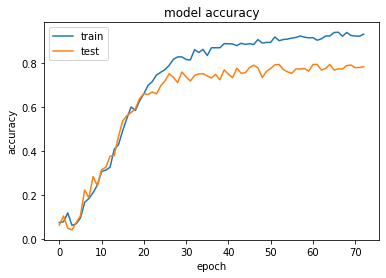

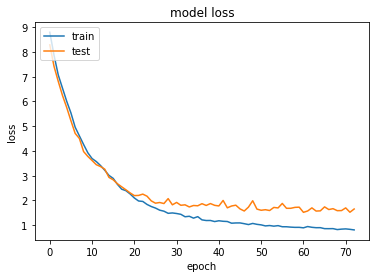

In [92]:
helpers.plotTrainingHistory(history.history)

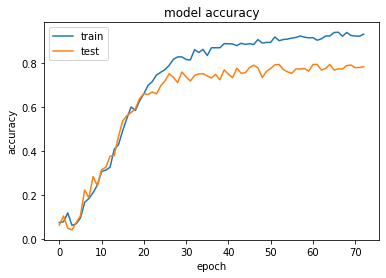

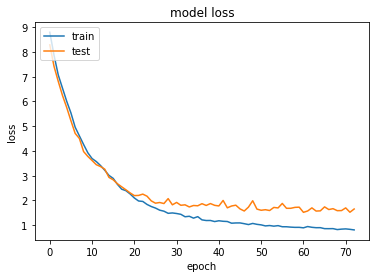

In [93]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

In [0]:
del model_1

In [95]:
model_1 = load_model(filepath_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [96]:
testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(test_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size,
                                            shuffle=False)

y_pred = model_1.predict_generator(test_generator, steps = test_generator.samples//batch_size+1, verbose=1)

Found 266 images belonging to 17 classes.
 1/34 [..............................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/34 [==============================] - 2s 45ms/step


In [0]:
le = LabelEncoder()
listLabel = list(test_generator.class_indices.keys())
le.fit(listLabel)
encodedLabel = le.transform(listLabel)

In [0]:
y_pred = np.argmax(y_pred, axis=1)

In [99]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.80      0.89      0.84        18
           2       0.88      0.93      0.90        15
           3       0.48      0.71      0.57        14
           4       0.94      0.94      0.94        16
           5       0.80      0.80      0.80        15
           6       1.00      0.87      0.93        15
           7       0.50      0.83      0.62        18
           8       0.00      0.00      0.00        14
           9       0.89      0.89      0.89        18
          10       1.00      0.88      0.93        16
          11       0.75      0.80      0.77        15
          12       1.00      0.87      0.93        15
          13       0.89      0.53      0.67        15
          14       1.00      0.94      0.97        18
          15       0.83      1.00      0.91        15
          16       0.86      0.80      0.83        15

    accuracy              

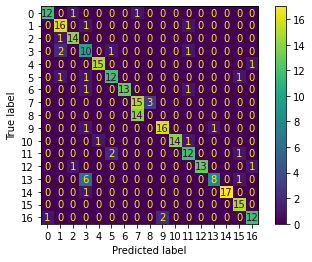

In [100]:
ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, y_pred), encodedLabel).plot()

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  

In [102]:
test_generator.class_indices

{'adho mukha svanasana': 0,
 'ardha matsyendrasana': 1,
 'astavakrasana': 2,
 'baddha konasana': 3,
 'bakasana': 4,
 'balasana': 5,
 'bhujangasana': 6,
 'bitilasana': 7,
 'chakravakasana': 8,
 'chaturanga dandasana': 9,
 'garudasana': 10,
 'gomukhasana': 11,
 'natarajasana': 12,
 'supta baddha konasana': 13,
 'ustrasana': 14,
 'utkatasana': 15,
 'vasisthasana': 16}

**Results Summary**